In [7]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve
import matplotlib.pyplot as plt
import gudhi as gd
from gtda.plotting import plot_diagram

import glob

In [8]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    max_count = max(pass_info["count"] for player in game for pass_info in player["passes"]) + 1
    
    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = max_count - count

            G.add_edge(player1, player2, weight=edge_weight)

    return G

def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

def getAUC(game):
    current_game = load_game_data(game)
    G_game = construct_adjacency_matrix(current_game)
    adj_matrix, nodes = graph_to_adjacency_matrix(G_game)

    vr_persistence = VietorisRipsPersistence(
        metric="precomputed",
        homology_dimensions=[0, 1, 2, 3],  # Compute H0 and H1
        collapse_edges=True  # Handle disconnected graphs
    )

    diagrams = vr_persistence.fit_transform([adj_matrix])[0]

    betti_transformer = BettiCurve(
        n_bins=100
    )

    betti_numbers = betti_transformer.fit_transform([diagrams])[0]

    homology_dimensions = len(vr_persistence.homology_dimensions)
    betti_numbers = betti_numbers.reshape(-1, homology_dimensions)

    betti0 = betti_numbers[:, 0]
    if homology_dimensions > 1:
        betti1 = betti_numbers[:, 1]
    else:
        betti1 = None

    min_distance = np.min(adj_matrix[np.isfinite(adj_matrix) & (adj_matrix > 0)])
    max_distance = np.max(adj_matrix[np.isfinite(adj_matrix)])
    filtration_values = np.linspace(min_distance, max_distance, num=100)

    auc_betti0 = np.trapz(betti0, filtration_values)
    auc_betti1 = np.trapz(betti1, filtration_values) if betti1 is not None else 0

    return auc_betti0, auc_betti1


/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: Runtime

3890345_Eintracht-Frankfurt_0_53.json: AUC Betti0 = 35.08080808080808, AUC Betti1 = 34.848484848484844, goals per 90 = 0.0
3890543_Hannover-96_1_70.json: AUC Betti0 = 22.303030303030305, AUC Betti1 = 22.545454545454547, goals per 90 = 1.2857142857142856
3890304_Ingolstadt_0_70.json: AUC Betti0 = 64.15151515151514, AUC Betti1 = 63.858585858585855, goals per 90 = 0.0
3890399_Bayern-Munich_0_50.json: AUC Betti0 = 30.060606060606066, AUC Betti1 = 29.73737373737374, goals per 90 = 0.0
3890389_Ingolstadt_0_63.json: AUC Betti0 = 63.03030303030304, AUC Betti1 = 62.06060606060606, goals per 90 = 0.0
3890406_Borussia-Dortmund_1_45.json: AUC Betti0 = 65.99999999999999, AUC Betti1 = 65.33333333333333, goals per 90 = 2.0
3890259_Hamburger-SV_0_59.json: AUC Betti0 = 16.333333333333332, AUC Betti1 = 16.12121212121212, goals per 90 = 0.0
3890519_Bayer-Leverkusen_2_55.json: AUC Betti0 = 31.272727272727273, AUC Betti1 = 31.090909090909093, goals per 90 = 3.2727272727272725
3890448_Eintracht-Frankfurt_0_

/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: Runtime

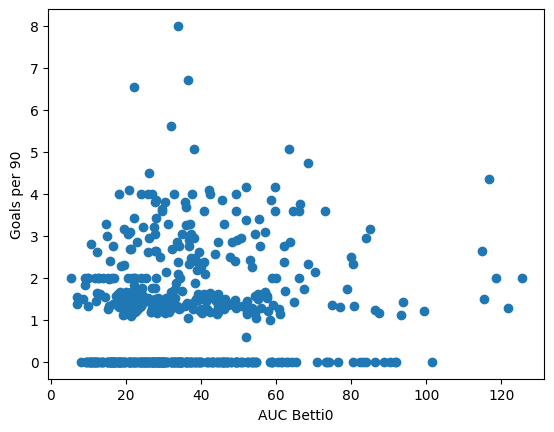

[[1.         0.99983997 0.11054175]
 [0.99983997 1.         0.11044442]
 [0.11054175 0.11044442 1.        ]]


In [ ]:
directory_path = '../data/2015-2016/1-Bundesliga/*.json'

auc_values = {}

for file_path in glob.glob(directory_path):
    filename = os.path.basename(file_path)
    filename_list = filename.split('_')
    goals = int(filename_list[-2])
    minutes = int(filename_list[-1].split('.')[0])

    goal_per_90 = goals / (minutes / 90)

    auc_betti0, auc_betti1 = getAUC(file_path)
    auc_values[filename] = (auc_betti0, auc_betti1, goal_per_90)

# Print the AUC values for each file
for filename, auc in auc_values.items():
    print(f"{filename}: AUC Betti0 = {auc[0]}, AUC Betti1 = {auc[1]}, goals per 90 = {auc[2]}")

auc_values_list = list(auc_values.values())
auc_values_list = np.array(auc_values_list)
plt.scatter(auc_values_list[:, 0], auc_values_list[:, 2])
plt.xlabel("AUC Betti0")
plt.ylabel("Goals per 90")
plt.show()

correlation_matrix = np.corrcoef(auc_values_list.T)
print(correlation_matrix)